In [1]:
require(cowplot)
require(data.table)
require(ggplot2)
require(ggpattern)
require(ggpubr)
require(pbapply)
pboptions(type="timer")

source("functions/plot_scatterplot_with_density_snr_value.R")

Loading required package: cowplot


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: data.table

Loading required package: ggplot2

Loading required package: ggpattern

Loading required namespace: memoise

Loading required package: ggpubr


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend


Loading required package: pbapply

Loading required package: ggforce



In [2]:
nthreads=10

In [3]:
dots_data0 = readRDS(file.path("/mnt/data/Imaging/202105-Deconwolf/data_210726",
                              "dots_data.rds"))[is.finite(SNR2) & SNR2 > 0 & Value2 > 0]
nuclear_features = fread("../data/selected_nuclei.tsv", key=c("sid", "nid"))

In [4]:
dots_data = rbindlist(pblapply(split(dots_data0, list(dots_data0$image_type, dots_data0$magnification)), function(subdata, nuclear_features) {
    setkeyv(subdata, c("series_id", "nid"))
    return(nuclear_features[subdata][!is.na(size)])
}, nuclear_features))
setnames(dots_data, "sid", "series_id")

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=09s  


# Panel X2.a
FWHM distribution of dots un/filtered by field-based threshold for 60x DW and raw, field #1.

In [5]:
ddata = dots_data[FWHM >= .5 & FWHM <= 5 & nid > 0]
setkeyv(ddata, c("series_id", "nid"))
ddata = nuclear_features[ddata][!is.na(size)]["60x" == magnification]

In [6]:
thr_data = fread("../data/60x_reference/intensity_thresholds.by_field.tsv")

In [7]:
# Apply threshold
ddata2 = rbindlist(by(ddata, ddata$sid, function(sdata) {
    sdata = copy(sdata)
    current_field_id = sdata[1, sid]
    dw_thr =  thr_data[image_type == "dw"  & sid == current_field_id, thr]
    raw_thr = thr_data[image_type == "raw" & sid == current_field_id, thr]
    sdata[, dot_type := "noisy"]
    sdata["dw"  == image_type & dw_thr  <= Value2, dot_type := "good"]
    sdata["raw" == image_type & raw_thr <= Value2, dot_type := "good"]
    return(sdata)
}))

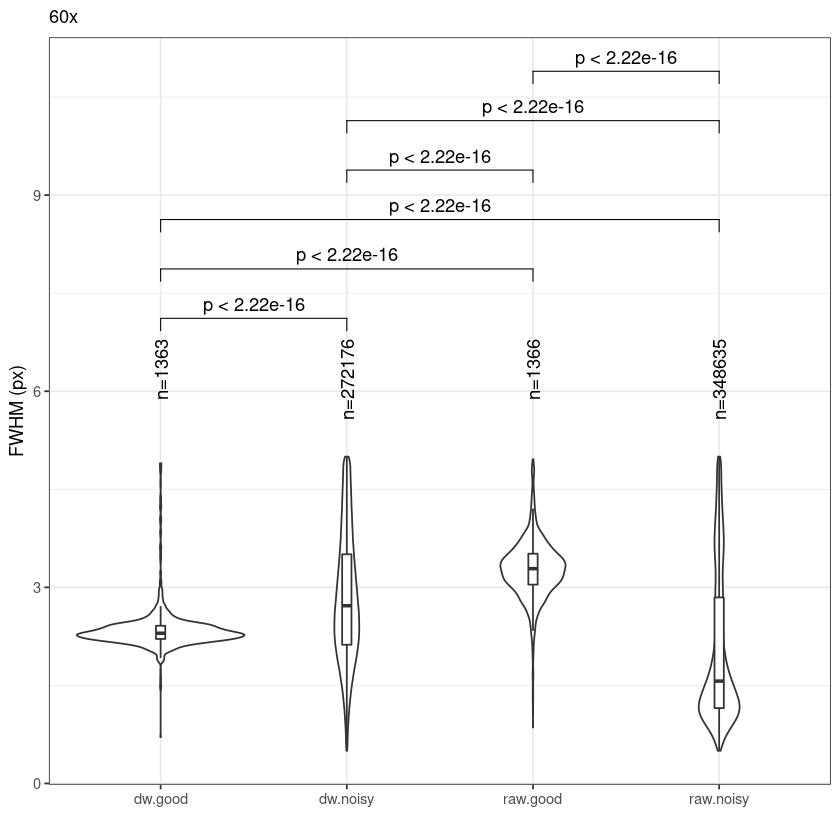

In [8]:
p = ggplot(ddata2[1 == sid], aes(x=paste0(image_type, ".", dot_type), y=FWHM)) +
    geom_violin(trim=T) + geom_boxplot(width=.05, outlier.shape=NA) +
    theme_bw() + labs(x="", y="FWHM (px)", subtitle="60x") +
    theme(legend.position="bottom") +
    stat_compare_means(method="wilcox.test", comparisons=combn(4, 2, simplify=F)) +
    geom_text(data=ddata2[1 == sid][, .N, by=c("image_type", "dot_type")],
              aes(y=6.8, label=paste0("n=", N)), angle=90, hjust=1, vjust=.5)
p

In [9]:
ggsave(plot=p, file="panels/supp_fig_x2a.png", width=4, height=4)
saveRDS(p, "panels_rds/supp_fig_x2a.rds")

# Panel X2.b
Column-plot with dot overlap between 60x raw and DW, by field.

In [10]:
counts = fread("../data/60x_reference/matched_dots.field_thr.counts.tsv")

In [11]:
pdata = rbindlist(list(
    counts[, .(series_id, dataset="60x.dw", matched=matched/dw_total)],
    counts[, .(series_id, dataset="60x.raw", matched=matched/raw_total)]
))
pdata[, unmatched := 1-matched]
pppdata = melt(pdata, id.vars=c("series_id", "dataset"))
pppdata$variable = factor(pppdata$variable, levels=c("unmatched", "matched"))

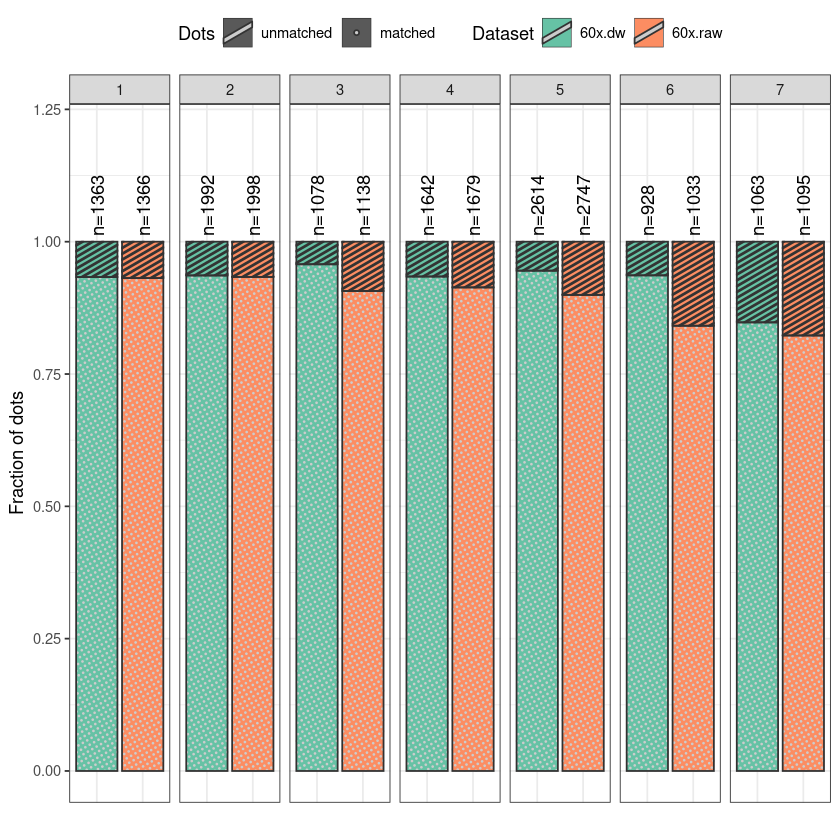

In [12]:
p = ggplot(pppdata, aes(x=dataset, y=value)) +
    geom_col_pattern(aes(fill=dataset, pattern=variable, pattern_color=variable), color="#323232") +
    facet_wrap(~series_id, nrow=1) +
    theme_bw() + theme(legend.position="top", axis.text.x=element_blank(), axis.ticks.x=element_blank()) +
    scale_fill_brewer("Dataset",  palette="Set2") + scale_pattern_color_grey() +
    labs(x="", y="Fraction of dots", pattern="Dots") +
    geom_text(data=counts, aes(x="60x.dw", y=1.01, label=paste0("n=", dw_total)), angle=90, hjust=0, vjust=.5) +
    geom_text(data=counts, aes(x="60x.raw", y=1.01, label=paste0("n=", raw_total)), angle=90, hjust=0, vjust=.5) +
    coord_cartesian(ylim=c(0, 1.2)) + guides(pattern_color="none")
print(p)

In [13]:
ggsave(plot=p, file="panels/supp_fig_x2b.png", width=4, height=4)
saveRDS(p, "panels_rds/supp_fig_x2b.rds")

# Panel X2.c
FWHM distribution of dots un/filtered by field-based threshold for 20x DW and raw, field #1.

In [14]:
ddata = dots_data[FWHM >= .5 & FWHM <= 5 & nid > 0]
setkeyv(ddata, c("series_id", "nid"))
ddata = nuclear_features[ddata][!is.na(size)]["20x" == magnification]

In [15]:
thr_data = fread("../data/magnifications_matching/intensity_thresholds.by_field.tsv")

In [16]:
# Apply threshold
ddata2 = rbindlist(by(ddata, ddata$sid, function(sdata) {
    sdata = copy(sdata)
    current_field_id = sdata[1, sid]
    dw_thr =  thr_data[image_type == "dw"  & sid == current_field_id, thr]
    raw_thr = thr_data[image_type == "raw" & sid == current_field_id, thr]
    sdata[, dot_type := "noisy"]
    sdata["dw"  == image_type & dw_thr  <= Value2, dot_type := "good"]
    sdata["raw" == image_type & raw_thr <= Value2, dot_type := "good"]
    return(sdata)
}))

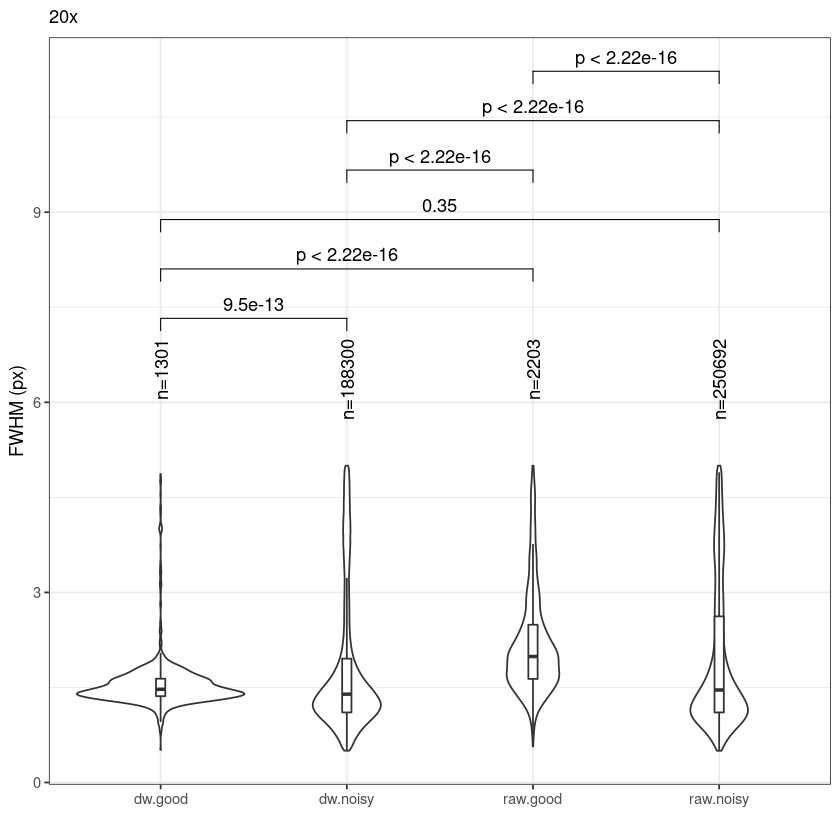

In [17]:
p = ggplot(ddata2[1 == sid], aes(x=paste0(image_type, ".", dot_type), y=FWHM)) +
    geom_violin(trim=T) + geom_boxplot(width=.05, outlier.shape=NA) +
    theme_bw() + labs(x="", y="FWHM (px)", subtitle="20x") +
    theme(legend.position="bottom") +
    stat_compare_means(method="wilcox.test", comparisons=combn(4, 2, simplify=F)) +
    geom_text(data=ddata2[1 == sid][, .N, by=c("image_type", "dot_type")],
              aes(y=7, label=paste0("n=", N)), angle=90, hjust=1, vjust=.5)
p

In [18]:
ggsave(plot=p, file="panels/supp_fig_x2c.png", width=4, height=4)
saveRDS(p, "panels_rds/supp_fig_x2c.rds")